In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from model import AutoEncoder_gnnrnn
from data import prepare_data_vocab, live_feat, batch_gnn_for_gpu, split_pp_into_sublists, split_train_test
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

[['store', 'double', 'TMP_VAR(INFUNCTION_VAR)', 'TMP_VAR', ';', 'load', 'TMP_VAR', 'double', 'TMP_VAR(INFUNCTION_VAR)', ';', 'assignment', 'TMP_POINTER_MEMBER', 'TMP_VAR', ';', 'assignment', 'TMP_VAR', 'TMP_POINTER_MEMBER', ';', 'math_op', 'TMP_VAR', 'TMP_NUMBER', '/', 'TMP_VAR', ';', 'function_call', 'INFUNCTION_VAR', 'TMP_FUNCTION_ARG_1', 'TMP_FUNCTION_ARG_2', ';', 'function_call', 'INFUNCTION_VAR', 'TMP_FUNCTION_ARG_1', 'TMP_FUNCTION_ARG_2', 'TMP_FUNCTION_ARG_3', 'TMP_FUNCTION_ARG_4', ';', 'math_op', 'TMP_VAR', 'TMP_VAR', '+', 'TMP_NUMBER', ';', 'assignment', 'INFUNCTION_VAR', 'TMP_VAR', ';', 'phi', ';']]


In [4]:
word_to_idx, idx_to_word, data, data_emb = prepare_data_vocab("data", func=live_feat, function_num=0)

In [6]:
bidir          = True
dir            = 2 if bidir else 1 
batch_size     = 128
num_layers_enc = 8
hidden_dim_enc = 32
num_layers_dec = 8
hidden_dim_dec = 32
emb_dim        = 32
N_max          = len(word_to_idx)+1
layer_dims_gnn = [16, 32, 16]

dataset = split_pp_into_sublists(data_emb, batch_size)
(train, test) = split_train_test(dataset)
ae = AutoEncoder_gnnrnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            layer_dims_gnn = layer_dims_gnn,
            emb_dim        = emb_dim,
            N_max          = N_max)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Or "cuda:0" for the first GPU
else:
    device = torch.device("cpu")

device = torch.device("cpu")
#ae.to(device)


train_gpu = batch_gnn_for_gpu(train, device, len(word_to_idx))
test_gpu = batch_gnn_for_gpu(test, device, len(word_to_idx))

criterion = nn.CrossEntropyLoss()
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 
optimizer = optim.Adam(ae.parameters(), lr=0.01)
epoch_num = 100
loss_list = []
accu_list = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, ratio=0.6)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%5==0:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive")
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_list.append(total_loss/cntBatch)
    accu_list.append(np.exp(-total_loss/cntBatch)*100)

For 55338 Tokens List in Train set: Epoch 1/100, Average Loss: 2.14043, Acuuracy: 11.76037
For 12385 Tokens List in Test set: Epoch 1/100, Average Loss: 0.49391, Acuuracy: 61.02369
-----------------------------------------------------------------------------------


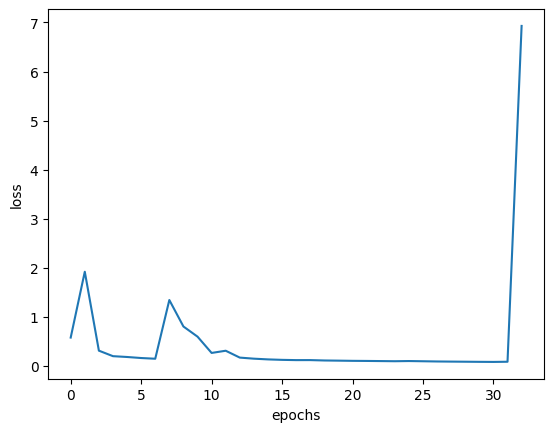

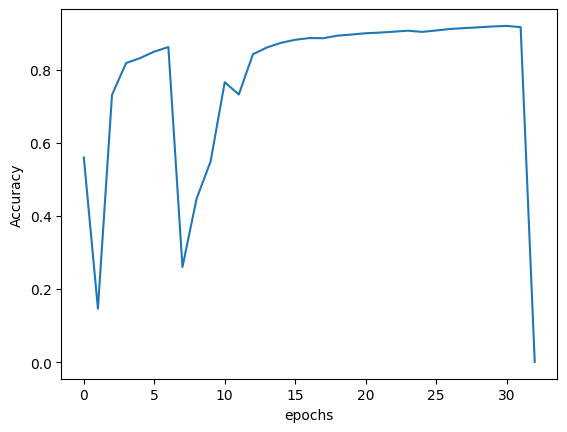

In [22]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()
plt.plot(accu_list)
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.show()

In [30]:
import torch.nn
emb = nn.Embedding(num_embeddings=10,
                   embedding_dim=13,
                   padding_idx= 9)

input = torch.LongTensor([[9]])
print(emb(input))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<EmbeddingBackward0>)
